<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/pt_to_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-auth
from google.colab import auth
from google.colab import drive

drive.mount('/content/drive')

# !pip install torchvision
!pip install onnx
# !pip install tensorflow
!pip install onnx_tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.onnx
from torch.autograd import Variable

# Define the PyTorch model class
class Model(nn.Module):
    def __init__(self, in_features=6, h1=61, h2=60, out_features=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
# Load the saved PyTorch model
model = Model()
model.load_state_dict(torch.load('/content/drive/MyDrive/airfoil_model.pt'))
model.eval()

Model(
  (fc1): Linear(in_features=6, out_features=61, bias=True)
  (fc2): Linear(in_features=61, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Define file paths
onnx_file_path = "/content/drive/MyDrive/airfoil_model.onnx"
dummy_input = torch.randn(1,6)

# Step 1: Export PyTorch model to ONNX format
def export_pytorch_to_onnx(model, dummy_input, onnx_file_path):
    torch.onnx.export(
        model,
        dummy_input,
        onnx_file_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output']
    )

In [ ]:
# Perform the conversion
export_pytorch_to_onnx(model, dummy_input, onnx_file_path)


In [ ]:
!pip install onnx2pytorch
import onnx
from onnx2pytorch import ConvertModel
import torch

# Load the ONNX model
onnx_model = onnx.load(onnx_file_path)

# Convert the ONNX model to a PyTorch model
pytorch_converted_model = ConvertModel(onnx_model)

# Save the converted PyTorch model state dictionary for later use if needed
torch.save(pytorch_converted_model.state_dict(), '/content/drive/MyDrive/converted_airfoil_model.pt')

In [ ]:
# Load the original PyTorch model and converted model for comparison
original_model = Model()
original_model.load_state_dict(torch.load('/content/drive/MyDrive/airfoil_model.pt'))
original_model.eval()

converted_model = ConvertModel(onnx_model)
converted_model.load_state_dict(torch.load('/content/drive/MyDrive/converted_airfoil_model.pt'))
converted_model.eval()

# Compare the weights
for (original_param, converted_param) in zip(original_model.parameters(), converted_model.parameters()):
    assert torch.allclose(original_param, converted_param, atol=1e-6), "The weights are different!"
print("All weights are correctly transferred.")

All weights are correctly transferred.


In [ ]:
import numpy as np

# Generate a sample input tensor
input_data = np.random.randn(1, 6).astype(np.float32)
pytorch_input = torch.from_numpy(input_data)

# Get the original PyTorch model output
with torch.no_grad():
    original_output = original_model(pytorch_input).numpy()

# Get the converted PyTorch model output
with torch.no_grad():
    converted_output = converted_model(pytorch_input).numpy()

# Compare the outputs
print("Original PyTorch Model Output:", original_output)
print("Converted PyTorch Model Output:", converted_output)

# Check if the outputs are close
if np.allclose(original_output, converted_output, atol=1e-12):
    print("The outputs are the same within the tolerance level.")
else:
    print("The outputs are different.")

Original PyTorch Model Output: [[0.94510525]]
Converted PyTorch Model Output: [[0.94510525]]
The outputs are the same within the tolerance level.


In [ ]:
import tensorflow as tf

# Define the TensorFlow model class
class KerasModel(tf.keras.Model):
    def __init__(self):
        super(KerasModel, self).__init__()
        self.fc1 = tf.keras.layers.Dense(61, activation='sigmoid')
        self.fc2 = tf.keras.layers.Dense(60, activation='sigmoid')
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

# Create an instance of the Keras model
keras_model = KerasModel()

# Build the Keras model with the input shape
keras_model.build(input_shape=(None, 6))

In [ ]:
import onnx

# Load ONNX model
onnx_model = onnx.load(onnx_file_path)

# Extract weights and biases from ONNX model
weights = {}
for initializer in onnx_model.graph.initializer:
    weights[initializer.name] = onnx.numpy_helper.to_array(initializer)


In [ ]:
# Assign the weights and biases to the TensorFlow model
keras_model.fc1.set_weights([weights['fc1.weight'].T, weights['fc1.bias']])
keras_model.fc2.set_weights([weights['fc2.weight'].T, weights['fc2.bias']])
keras_model.out.set_weights([weights['out.weight'].T, weights['out.bias']])

# Perform a forward pass with dummy data to ensure initialization
dummy_input = tf.random.normal([1, 6])
keras_model(dummy_input)

# Save the Keras model
final_tf_export_path = '/content/drive/MyDrive/tf_final'
tf.keras.models.save_model(keras_model, final_tf_export_path, save_format='tf')


In [ ]:
import numpy as np

# Generate a sample input tensor
input_data = np.random.randn(1, 6).astype(np.float32)

# Convert the numpy array to a PyTorch tensor
pytorch_input = torch.from_numpy(input_data)

# Get the PyTorch model output
with torch.no_grad():
    pytorch_output = model(pytorch_input).numpy()

# Load the final TensorFlow model
tf_model_final = tf.keras.models.load_model(final_tf_export_path)

# Get the TensorFlow model output
tf_output = tf_model_final(input_data).numpy()

# Compare the outputs
print("PyTorch Model Output:", pytorch_output)
print("TensorFlow Model Output:", tf_output)

# Check if the outputs are close
if np.allclose(pytorch_output, tf_output, atol=1e-12):
    print("The outputs are the same within the tolerance level.")
else:
    print("The outputs are different.")


PyTorch Model Output: [[0.9591084]]
TensorFlow Model Output: [[0.95910835]]
The outputs are the same within the tolerance level.


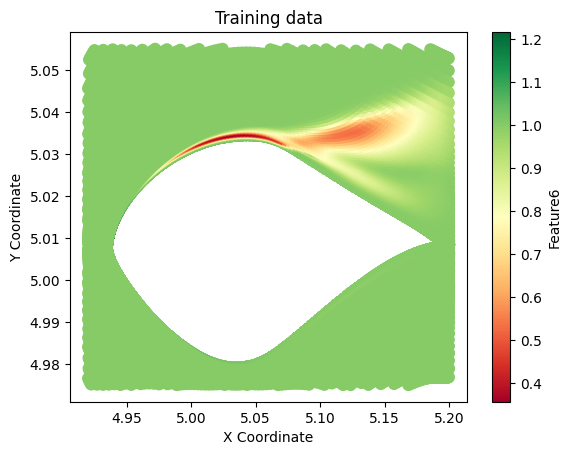

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dff = pd.read_csv("/content/drive/MyDrive/data_set3.csv")

# dff.loc[dff['beta']<0.995, "beta"] = 1.5
# dff.loc[dff['beta']>1.005, "beta"] = 1.5


frames = [dff]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        # if (b[i]<0.995) | (b[i]>1.005):
          x1.append(xc[i])
          y1.append(yc[i])
          b1.append(b[i])
          f1.append(ff1[i])
          f2.append(ff2[i])
          f3.append(ff3[i])
          f4.append(ff4[i])
          f5.append(ff5[i])
          f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # Create a scatter plot
  plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Feature6')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Training data')
  plt.show()
###############################################################################

dff1 = pd.concat(ff)

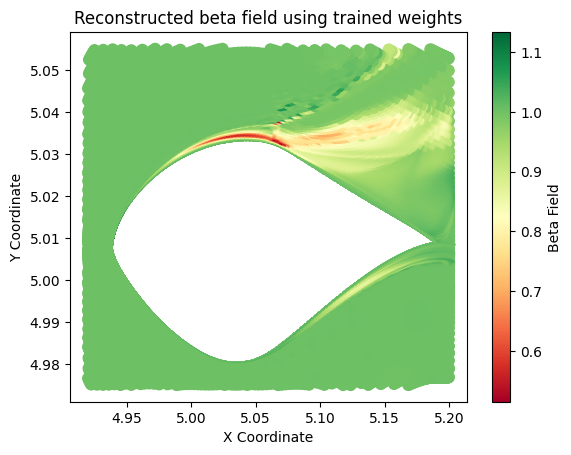

In [ ]:
dff2 = dff1.drop(['x','y','beta'],axis=1)
X2 = dff2.values
X2 = torch.FloatTensor(X2)
y2 = model.forward(X2)
y2 = y2.detach().numpy()

# Create a scatter plot
plt.scatter(x1, y1, c=y2,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
plt.colorbar(label='Beta Field')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Reconstructed beta field using trained weights')
plt.show()


In [ ]:
X3 = dff2.values
X3 = np.array(X3,dtype=np.float32)
y3 = tf_model_final.predict(X3)

1530/1530 [==============================] - 4s 3ms/step


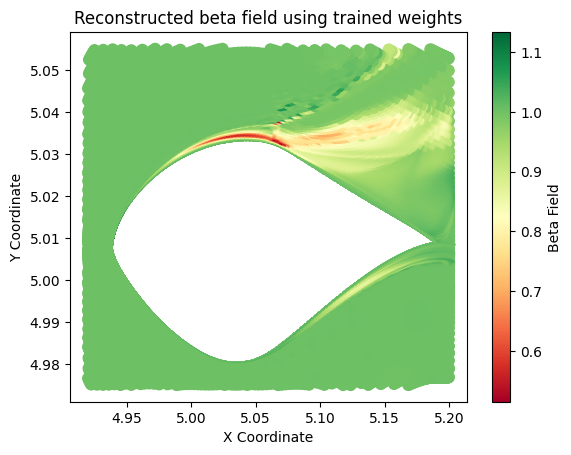

In [ ]:
# Create a scatter plot
plt.scatter(x1, y1, c=y3,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
plt.colorbar(label='Beta Field')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Reconstructed beta field using trained weights')
plt.show()